In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
from tqdm import tqdm
import xgboost as xgb
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet18 import ResNet18
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten, Input
import scipy
from sklearn.metrics import fbeta_score
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model,Sequential,  load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
#from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

In [33]:
disease_types=['Apple___Apple_scab','Apple___Black_rot', 'Apple___Cedar_apple_rust','Apple___healthy',
               'Grape___healthy', 'Grape___Leaf_blight', 'Grape___Esca', 'Grape___Black_rot',
               'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

data_dir = '/content/drive/MyDrive/BitkiHastaligiTeshisi - OzgeOzaras/Mini_SqueezeNet_New/Kodlar/dataset'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices

In [34]:
IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [35]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

9385it [01:03, 147.70it/s]


Train Shape: (9385, 224, 224, 3)


In [36]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train)

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [9]:
pip install keras_applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00


In [10]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
#from keras.engine.topology import get_source_inputs
from keras.utils import get_file
#from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '-'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                     require_flatten = False)

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    #x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    #x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    #x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    #x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [11]:
X_train.shape[0:]

(7508, 224, 224, 3)

In [12]:
import tensorflow as tf


# Create the SqueezeNet model
model = SqueezeNet(input_shape=(X_train.shape[1:]), weights=None, classes=Y_train.shape[1], use_bn_on_input=True)

# Set the learning rate
learning_rate = 0.0001

# Initiate Adam optimizer with the correct argument
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Print the model summary
model.summary()

# (Optional) Prepare to train the model and store loss history
loss_history = []


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "squeezenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 3)    │             12 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 111, 111, 64)   │          1,792 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu_conv1 (Activation)   │ (None, 111, 111, 64)   │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 55, 55, 64)     │              0 │ relu_conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          1,040 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire2-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire2-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand1x1      │ (None, 55, 55, 64)     │              0 │ fire2-expand1x1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-relu_expand3x3      │ (None, 55, 55, 64)     │              0 │ fire2-expand3x3[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire2-concat              │ (None, 55, 55, 128)    │              0 │ fire2-relu_expand1x1[… │
│ (Concatenate)             │                        │                │ fire2-relu_expand3x3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-squeeze1x1 (Conv2D) │ (None, 55, 55, 16)     │          2,064 │ fire2-concat[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-relu_squeeze1x1     │ (None, 55, 55, 16)     │              0 │ fire3-squeeze1x1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand1x1 (Conv2D)  │ (None, 55, 55, 64)     │          1,088 │ fire3-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-expand3x3 (Conv2D)  │ (None, 55, 55, 64)     │          9,280 │ fire3-relu_squeeze1x1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fire3-relu_expand1x1 

 Total params: 123,255 (481.46 KB)

 Trainable params: 123,249 (481.44 KB)

 Non-trainable params: 6 (24.00 B)

In [13]:
EPOCHS = 150
BATCH_SIZE=64
SIZE=224
N_ch=3

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])


In [15]:
hist=model.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/150
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1758 - loss: 2.3323
Epoch 1: val_accuracy improved from -inf to 0.23921, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.1759 - loss: 2.3318 - val_accuracy: 0.2392 - val_loss: 2.3132
Epoch 2/150
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3473 - loss: 1.9378
Epoch 2: val_accuracy improved from 0.23921 to 0.38892, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3477 - loss: 1.9367 - val_accuracy: 0.3889 - val_loss: 1.9042
Epoch 3/150
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4590 - loss: 1.5969
Epoch 3: val_accuracy improved from 0.38892 to 0.51731, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4594 - loss: 1.5954 - val_accuracy: 0.5173 - val_loss: 1.4780
Epoch 4/150
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5205 - loss: 1.4085
Epoch 4: val_accuracy improve

In [16]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [17]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [18]:
y_pred=np.argmax(y_pred, axis=1)

In [19]:
Y_val=np.argmax(Y_val, axis=1)

In [20]:
print("SquezeNet MODEL SONUÇLARI")
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

SquezeNet MODEL SONUÇLARI
Doğruluk:  0.9738945125199787
F1_Skor:  0.9671694858577353
Hassasiyet:  0.9787277194962816
Duyarlılık:  0.9588346500508902


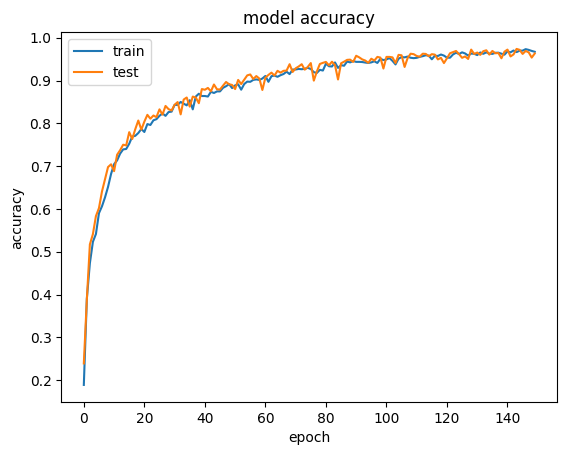

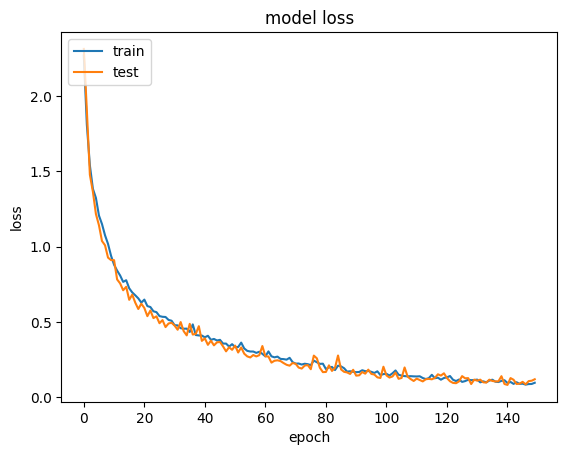

In [21]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[112   1   0   3   0   0   0   0   0   0   2]
 [  0 128   0   0   1   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  2   0   0 360   0   0   0   0   0   0   0]
 [  0   0   0   1  76   0   0   0   0   0   0]
 [  1   0   0   0   0 208   0   5   0   0   0]
 [  0   0   0   0   0   0 241  13   1   0   0]
 [  0   0   0   1   0   0   1 249   0   0   1]
 [  0   0   0   1   0   2   0   1 176   0   2]
 [  0   0   0   0   0   0   0   0   0  23   7]
 [  3   0   0   0   0   0   0   0   0   0 203]]


<Axes: >

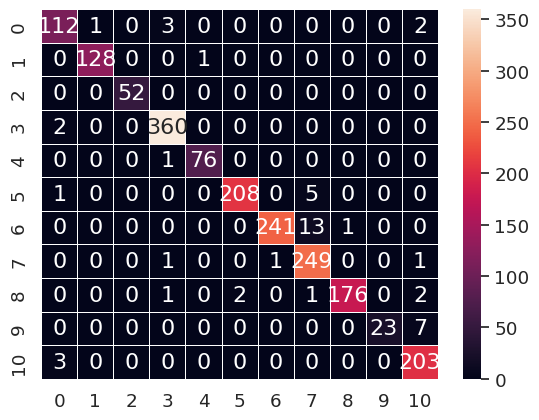

In [22]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size

# vgg16

In [38]:
EPOCHS = 100
BATCH_SIZE=64
SIZE=224
N_ch=3

In [39]:
def build_vgg():
    vgg = VGG16(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = vgg(x)
    x = Flatten(name="flatten")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    # multi output
    output = Dense(11,activation = 'softmax', name='root')(x)
    # model
    model = Model(input,output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [40]:
model_vgg = build_vgg()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ root (Dense)                         │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,141,407 (80.65 MB)

 Trainable params: 21,140,895 (80.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Update filepath to use .keras extension
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# You can now fit your model and include these callbacks
# Example:
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[es, mc])

In [42]:
hist_vgg16=model_vgg.fit(X_train, Y_train,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               validation_data=(X_val, Y_val),
               callbacks=[es,mc])

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4160 - loss: 2.0345
Epoch 1: val_accuracy improved from -inf to 0.75812, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - accuracy: 0.4175 - loss: 2.0283 - val_accuracy: 0.7581 - val_loss: 0.9321
Epoch 2/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8585 - loss: 0.4140
Epoch 2: val_accuracy improved from 0.75812 to 0.92968, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.8589 - loss: 0.4128 - val_accuracy: 0.9297 - val_loss: 0.2389
Epoch 3/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9482 - loss: 0.1628
Epoch 3: val_accuracy improved from 0.92968 to 0.96324, saving model to best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.9483 - loss: 0.1624 - val_accuracy: 0.9632 - val_loss: 0.1091
Epoch 4/100
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9727 - loss: 0.0915
Epoch 4: val_accurac

In [43]:
from tensorflow.keras.models import load_model

# Load the saved model using the correct file extension
saved_model = load_model('best_model.keras')

In [44]:
y_pred = saved_model.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [45]:
y_pred=np.argmax(y_pred, axis=1)

In [46]:
Y_val=np.argmax(Y_val, axis=1)

In [47]:
print("SquezeNet MODEL SONUÇLARI")
print("Doğruluk: ",accuracy_score(Y_val, y_pred))
print("F1_Skor: ", f1_score(Y_val, y_pred,average="macro"))
print("Hassasiyet: ",precision_score(Y_val, y_pred,average="macro"))
print("Duyarlılık: ", recall_score(Y_val, y_pred,average="macro"))

SquezeNet MODEL SONUÇLARI
Doğruluk:  0.9978689397975493
F1_Skor:  0.9940907468636916
Hassasiyet:  0.9982683982683983
Duyarlılık:  0.9904095904095904


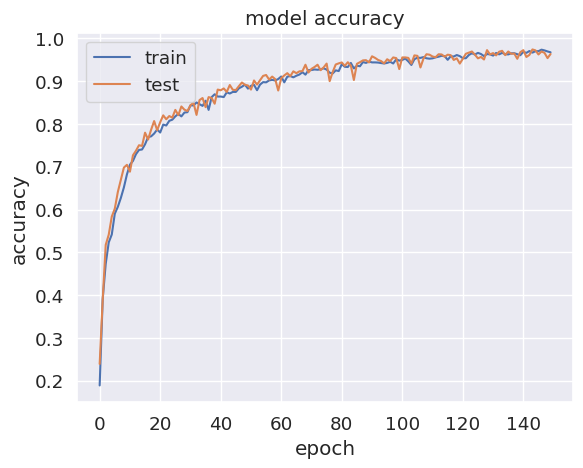

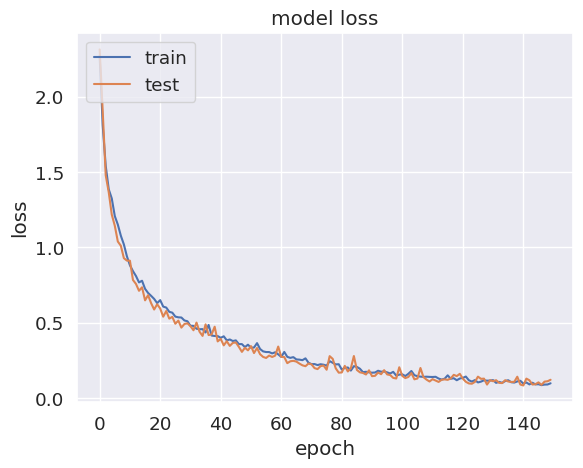

In [48]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[118   0   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0   0]
 [  0   0  52   0   0   0   0   0   0   0   0]
 [  0   0   0 362   0   0   0   0   0   0   0]
 [  0   0   0   0  77   0   0   0   0   0   0]
 [  0   0   0   0   0 214   0   0   0   0   0]
 [  0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0   0   0 252   0   0   0]
 [  0   0   0   0   0   0   0   0 181   0   1]
 [  0   0   0   0   0   0   0   0   0  27   3]
 [  0   0   0   0   0   0   0   0   0   0 206]]


<Axes: >

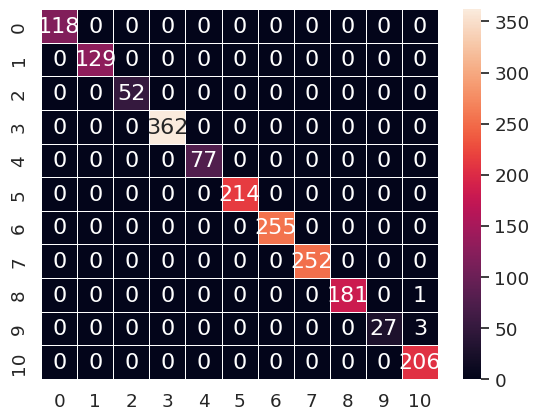

In [49]:
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_val, y_pred)
print(cm)
sn.set(font_scale=1.2)#for label size
sn.heatmap(cm, annot=True,fmt="d", linewidths=.5 ,annot_kws={"size": 16})# font size